In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from pickle import dump, load
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier




In [2]:
def load_images(images_folder, save_file_to=None):
    
    X_original = []
    X = []
    y = []
    
    for subdir, dirs, files in os.walk(images_folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                
                image = Image.open(img_path).convert('L')
                image = image.resize((48, 48))
                X_original.append(np.array(image).flatten())
                X.append(np.array(image).flatten())
                y.append(label)
                
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_original, X, y), f, protocol=5)
                
    return np.array(X_original), np.array(X), np.array(y)

images_folder = '/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/images'
dataset_file = "dataset_dump.pkl"

# Load images and save the dataset for reuse
X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

In [3]:
with open("dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)
    
X
y

['happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',


In [4]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [5]:
def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  # Normalize to [0, 1]
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Dimensionality reduction with PCA
    pca = PCA(n_components=100)
    X_reduced = pca.fit_transform(X)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reduced)
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, pca, scaler), f, protocol=5)
    
    return X_scaled, y_encoded, label_encoder, pca, scaler

X_scaled, y_encoded, label_encoder, pca, scaler = preprocessing_data(X, y, save_file_to="labelencoder_standardscaler_pca_normalizers_dump.pkl")

# with open("knn_standardscaler_gridsearch_normalizers_dump.pkl", "wb") as f:
#     dump((label_encoder, pca, scaler), f, protocol=5)

In [6]:
with open("labelencoder_standardscaler_pca_normalizers_dump.pkl", "rb") as f:
    X_scaled, y_encoded, label_encoder, pca, scaler = load(f)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [8]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, label_encoder):
    param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4]
    }

    
    best_combination = None
    best_accuracy = 0
    
    all_combinations = list(ParameterGrid(param_grid))
    for combination in all_combinations:
        print(combination)
        knn_model = KNeighborsClassifier(**combination)
        knn_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = knn_model.predict(X_test)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination
            
 # Print the best combination
    print("\nBest Combination:", best_combination)
    print(f"Best Accuracy: {best_accuracy:.2f}")
    print("\nTotal combinations:", len(all_combinations))

    # Train the best model on the entire training set
    best_model = KNeighborsClassifier(**best_combination)
    best_model.fit(X_train, y_train)

    # Save the best model
    with open("knn_model_standardscaler_grisearch_pca_dump.pkl", "wb") as f:
        dump(best_model, f, protocol=5)
    print("Best model saved successfully!")

    return best_model, best_combination

best_model, best_combination = train_and_evaluate_knn(X_train, y_train, X_test, y_test, label_encoder)



{'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.29      0.33       970
     disgust       0.27      0.39      0.32       107
        fear       0.36      0.34      0.35      1015
       happy       0.51      0.42      0.46      1824
     neutral       0.30      0.46      0.36      1260
         sad       0.34      0.30      0.32      1226
    surprise       0.60      0.59      0.60       776

    accuracy                           0.40      7178
   macro avg       0.39      0.40      0.39      7178
weighted avg       0.41      0.40      0.40      7178

{'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.29      0.33       970
     disgust       0.27      0.39      0.32       107
        fear       

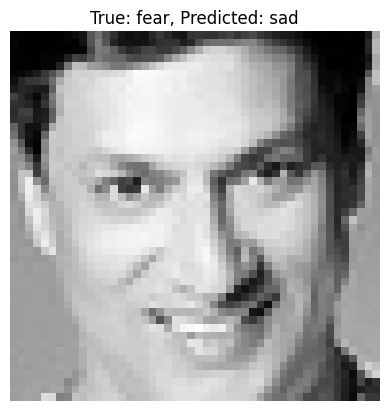

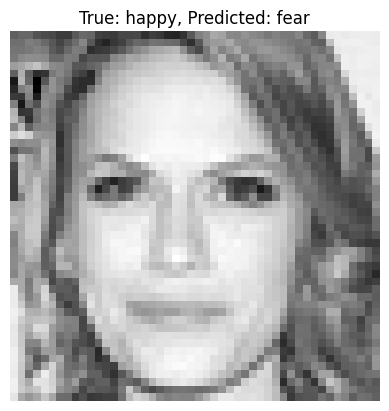

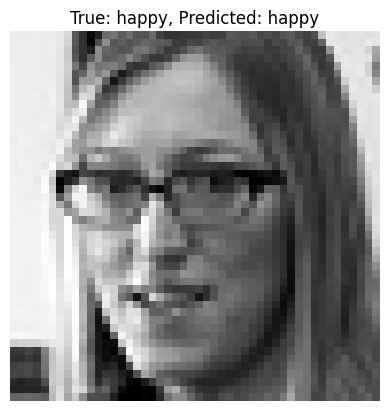

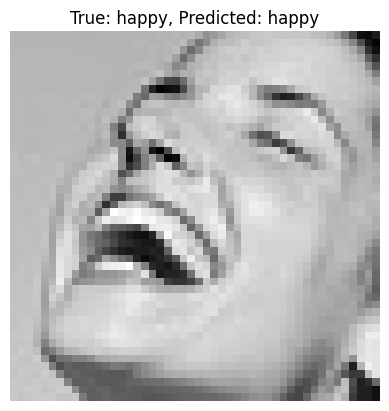

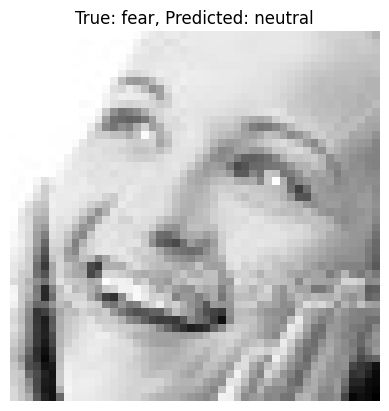

In [9]:
def visualize_predictions(best_model, X_test, y_test, label_encoder, X_original):
    y_pred = best_model.predict(X_test)
    random_indices = np.random.randint(0, len(y_test), 5)
    
    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape to 48x48
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

visualize_predictions(best_model, X_test, y_test, label_encoder, X_original)

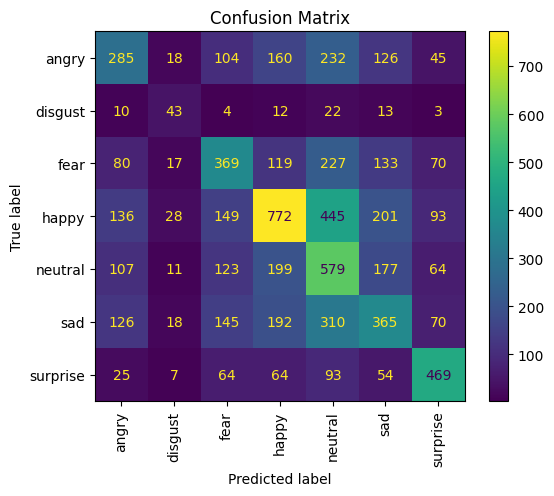

In [10]:
def plot_confusion_matrix(best_model, X_test, y_test, label_encoder):
    # Predict the labels for the test set
    y_pred = best_model.predict(X_test)
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(best_model, X_test, y_test, label_encoder)

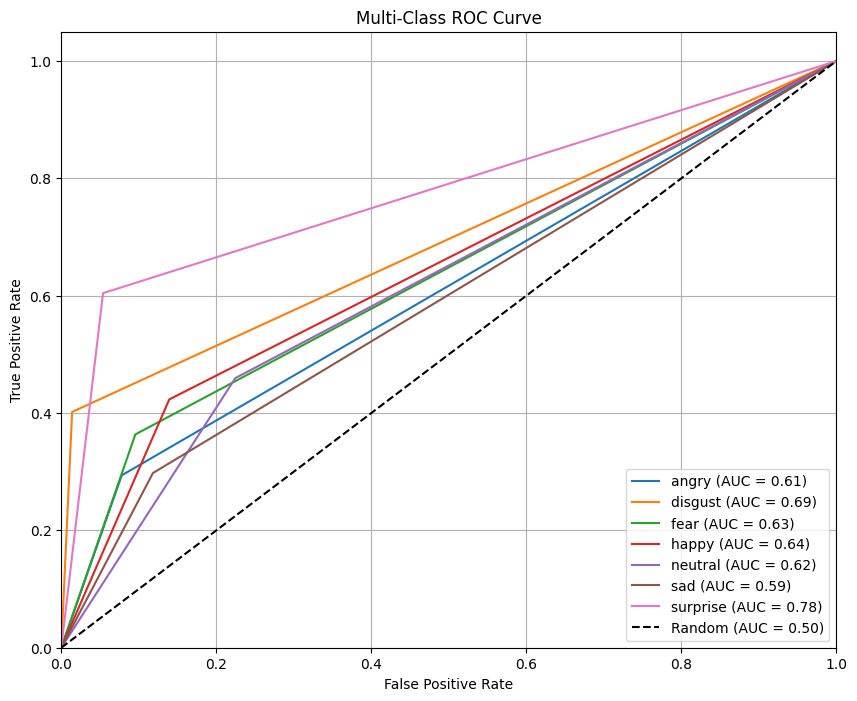

In [12]:
def plot_roc_curves(model, X_train, y_train, X_test, y_test, label_encoder):

    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    n_classes = y_test_binarized.shape[1]

    # Use OneVsRestClassifier to handle multi-class
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
plot_roc_curves(best_model, X_train, y_train, X_test, y_test, label_encoder)
